In [1]:
import pandas as pd

data = pd.read_csv("../data/design-seeds.csv")

In [2]:
data

,image_path,palette_path
0,data/design-seeds-data/0.jpg,data/design-seeds-data/0.npy
1,data/design-seeds-data/1.jpg,data/design-seeds-data/1.npy
2,data/design-seeds-data/2.jpg,data/design-seeds-data/2.npy
3,data/design-seeds-data/3.jpg,data/design-seeds-data/3.npy
4,data/design-seeds-data/4.jpg,data/design-seeds-data/4.npy
...,...,...
83,data/design-seeds-data/83.jpg,data/design-seeds-data/83.npy
84,data/design-seeds-data/84.jpg,data/design-seeds-data/84.npy
85,data/design-seeds-data/85.jpg,data/design-seeds-data/85.npy
86,data/design-seeds-data/86.jpg,data/design-seeds-data/86.npy


In [3]:
from repalette.utils import NaiveRecolorDataset

dataset = NaiveRecolorDataset(data, multiplier=21, resize=(128, 128))

In [4]:
from torch.utils.data import random_split

full_length = len(dataset)
train_length = int(full_length * 0.6)
val_length = int((full_length - train_length) / 2)
test_lendth = full_length - train_length - val_length

lengths = (train_length, val_length, test_lendth)

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

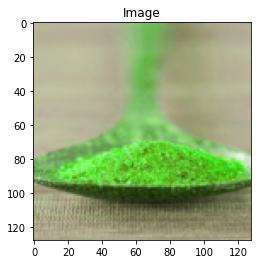

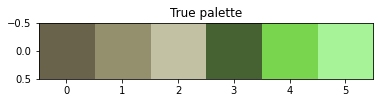

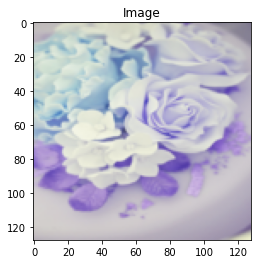

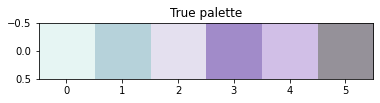

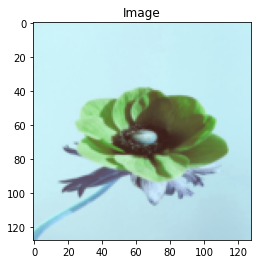

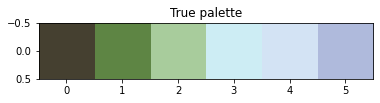

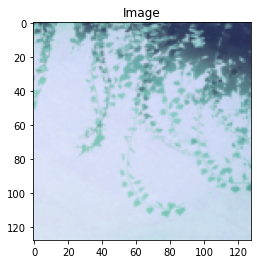

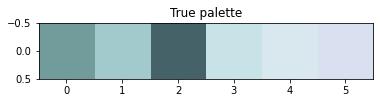

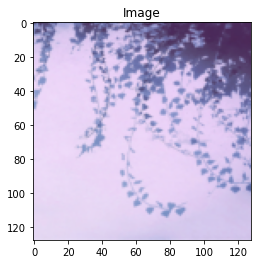

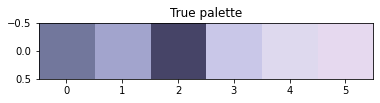

In [8]:
from matplotlib import pyplot as plt
import torch

i = 0
for x, y_true in iter(test_dataset):
    if i < 5:
        i += 1
    else:
        break

    plt.imshow(x.cpu().permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.show()

    plt.imshow(y_true.cpu().permute(1, 2, 0).numpy())
    plt.title("True palette")
    plt.show()

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16)

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from repalette.constants import MODELS_DIR
from repalette.models import PaletteExctractorNet

checkpoint_callback = ModelCheckpoint(
    filepath=MODELS_DIR,
    verbose=True,
    mode='min'
)

early_stop_callback = EarlyStopping(
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='min'
)

hparams = dict(dropout=0.2, learning_rate=1e-4)
model = PaletteExctractorNet(hparams)

trainer = Trainer(
    gpus=1, # user gpu!
    checkpoint_callback=checkpoint_callback,
    early_stop_callback=early_stop_callback,
)  

/home/dan/miniconda3/envs/repalette/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [15]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name            | Type    | Params
--------------------------------------------
0 | flatten         | Flatten | 0     
1 | dropout         | Dropout | 0     
2 | act2            | ReLU    | 0     
3 | linear_features | Linear  | 18 M  
4 | act3            | ReLU    | 0     
5 | palette_mapper  | Linear  | 6 K   
6 | sigmoid         | Sigmoid | 0     



Epoch 00012: val_checkpoint_on reached 0.03416 (best 0.03416), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=12_v0.ckpt as top 1



Epoch 00013: val_checkpoint_on reached 0.03407 (best 0.03407), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=13.ckpt as top 1


1

In [16]:
model.hparams["learning_rate"]

1.0000000000000002e-06

In [14]:
model.hparams["learning_rate"] /= 10

In [6]:
best_model = PaletteExctractorNet.load_from_checkpoint(
    "/home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=13.ckpt"
)

In [18]:
trainer.test(best_model, test_dataloader)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0360817089676857}
--------------------------------------------------------------------------------



[{'test_loss': 0.0360817089676857}]

In [11]:
batch = next(iter(test_dataloader))

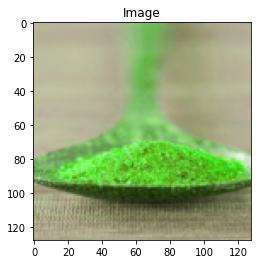

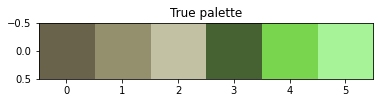

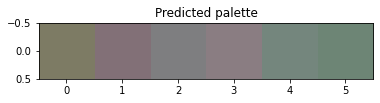

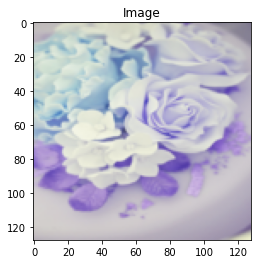

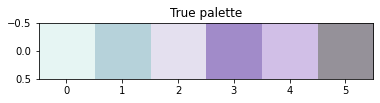

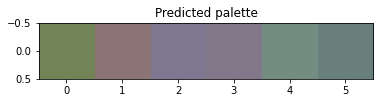

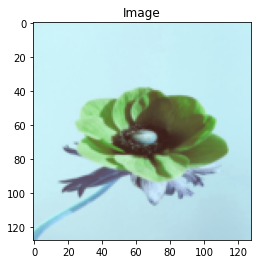

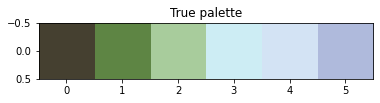

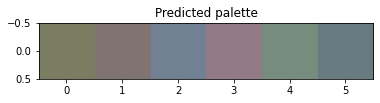

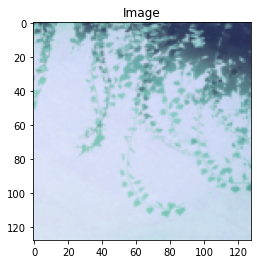

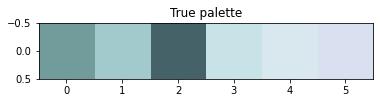

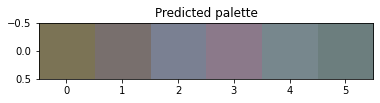

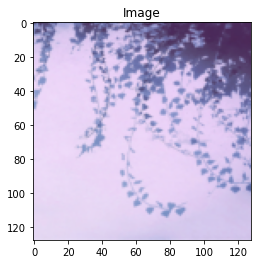

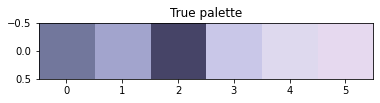

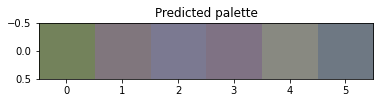

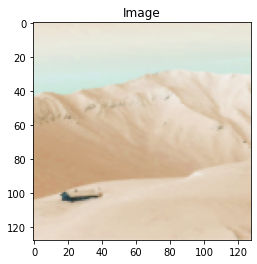

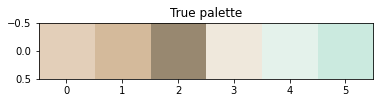

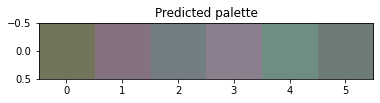

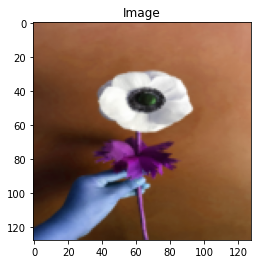

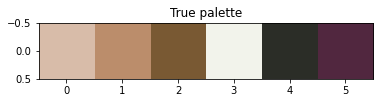

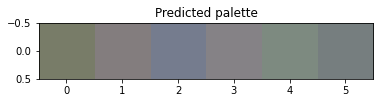

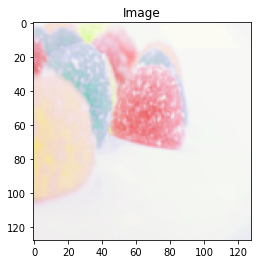

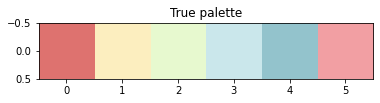

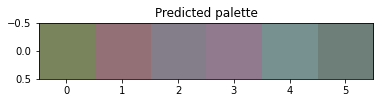

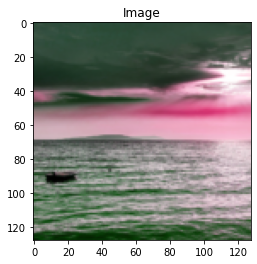

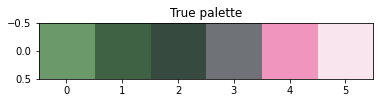

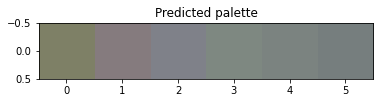

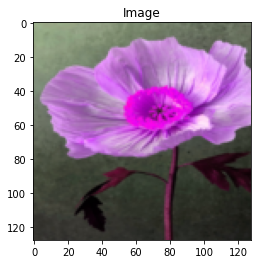

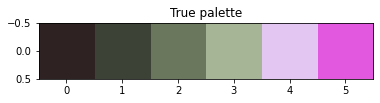

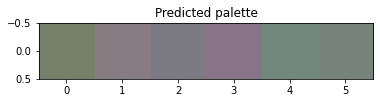

In [12]:
from matplotlib import pyplot as plt
import torch

best_model.eval()
i = 0
for x, y_true in zip(batch[0], batch[1]):
    if i < 10:
        i += 1
    else:
        break
    with torch.no_grad():
        y_pred = model(x.unsqueeze(0))

    plt.imshow(x.cpu().permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.show()

    plt.imshow(y_true.cpu().permute(1, 2, 0).numpy())
    plt.title("True palette")
    plt.show()

    plt.imshow(y_pred.cpu().squeeze(0).permute(1, 2, 0).numpy())
    plt.title("Predicted palette")
    plt.show()

torch.Size([32, 3, 1, 6])

In [16]:
model(x.unsqueeze(0)).shape

torch.Size([1, 3, 1, 6])